# 📊 Notebook 4 : Évaluation et Comparaison Finale
## Ames Housing - Analyse Approfondie des Performances

---

### 📋 Table des Matières
1. [Configuration et Chargement](#1-configuration)
2. [Métriques Détaillées](#2-métriques)
3. [Analyse des Erreurs](#3-erreurs)
4. [Analyse des Prédictions](#4-prédictions)
5. [Feature Importance](#5-importance)
6. [Courbes d'Apprentissage](#6-courbes)
7. [Sélection Finale](#7-sélection)
8. [Sauvegarde du Modèle Final](#8-sauvegarde)

---
## 1. Configuration et Chargement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy import stats
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
print('✅ Configuration chargée!')

✅ Configuration chargée!


In [2]:
# Charger les résultats et données
results_df = pd.read_csv('../models/models_comparison.csv')
df = pd.read_csv('../data/data_preprocessed.csv')

with open('../models/best_model.pkl', 'rb') as f:
    saved = pickle.load(f)
    best_model = saved['model']

print(f'📊 Résultats: {len(results_df)} modèles')
print(f'🏆 Meilleur modèle chargé')

📊 Résultats: 20 modèles
🏆 Meilleur modèle chargé


---
## 2. Métriques Détaillées

In [3]:
# Tableau récapitulatif
print('📊 CLASSEMENT COMPLET DES MODÈLES:')
print('='*80)
display_cols = ['Model', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Time']
print(results_df[display_cols].to_string(index=False))

📊 CLASSEMENT COMPLET DES MODÈLES:
             Model   Test_R2    Test_RMSE     Test_MAE     Time
       Extra Trees  0.914177 21773.013082 15602.780990 0.257889
  Voting Regressor  0.909441 22365.690905 15212.339098 0.988070
 Gradient Boosting  0.907617 22589.745585 15434.100702 0.878181
           XGBoost  0.907050 22658.964495 15276.801758 0.158582
     Random Forest  0.899259 23589.562212 16127.179147 0.402052
Stacking Regressor  0.898357 23694.948692 15899.476496 4.875754
 Bagging Regressor  0.895839 23986.589951 16548.308755 0.638477
   Huber Regressor  0.871275 26665.411270 18912.210842 0.073939
             Ridge  0.844323 29324.385901 20988.966364 0.011959
    Bayesian Ridge  0.843145 29435.097584 21272.288744 0.015725
        ElasticNet  0.830313 30615.407204 21284.550359 1.516471
 Linear Regression  0.825074 31084.478894 21326.158761 0.046101
             Lasso  0.824398 31144.433900 21370.996476 1.526618
     Decision Tree  0.796604 33518.705233 22877.525019 0.023655
      

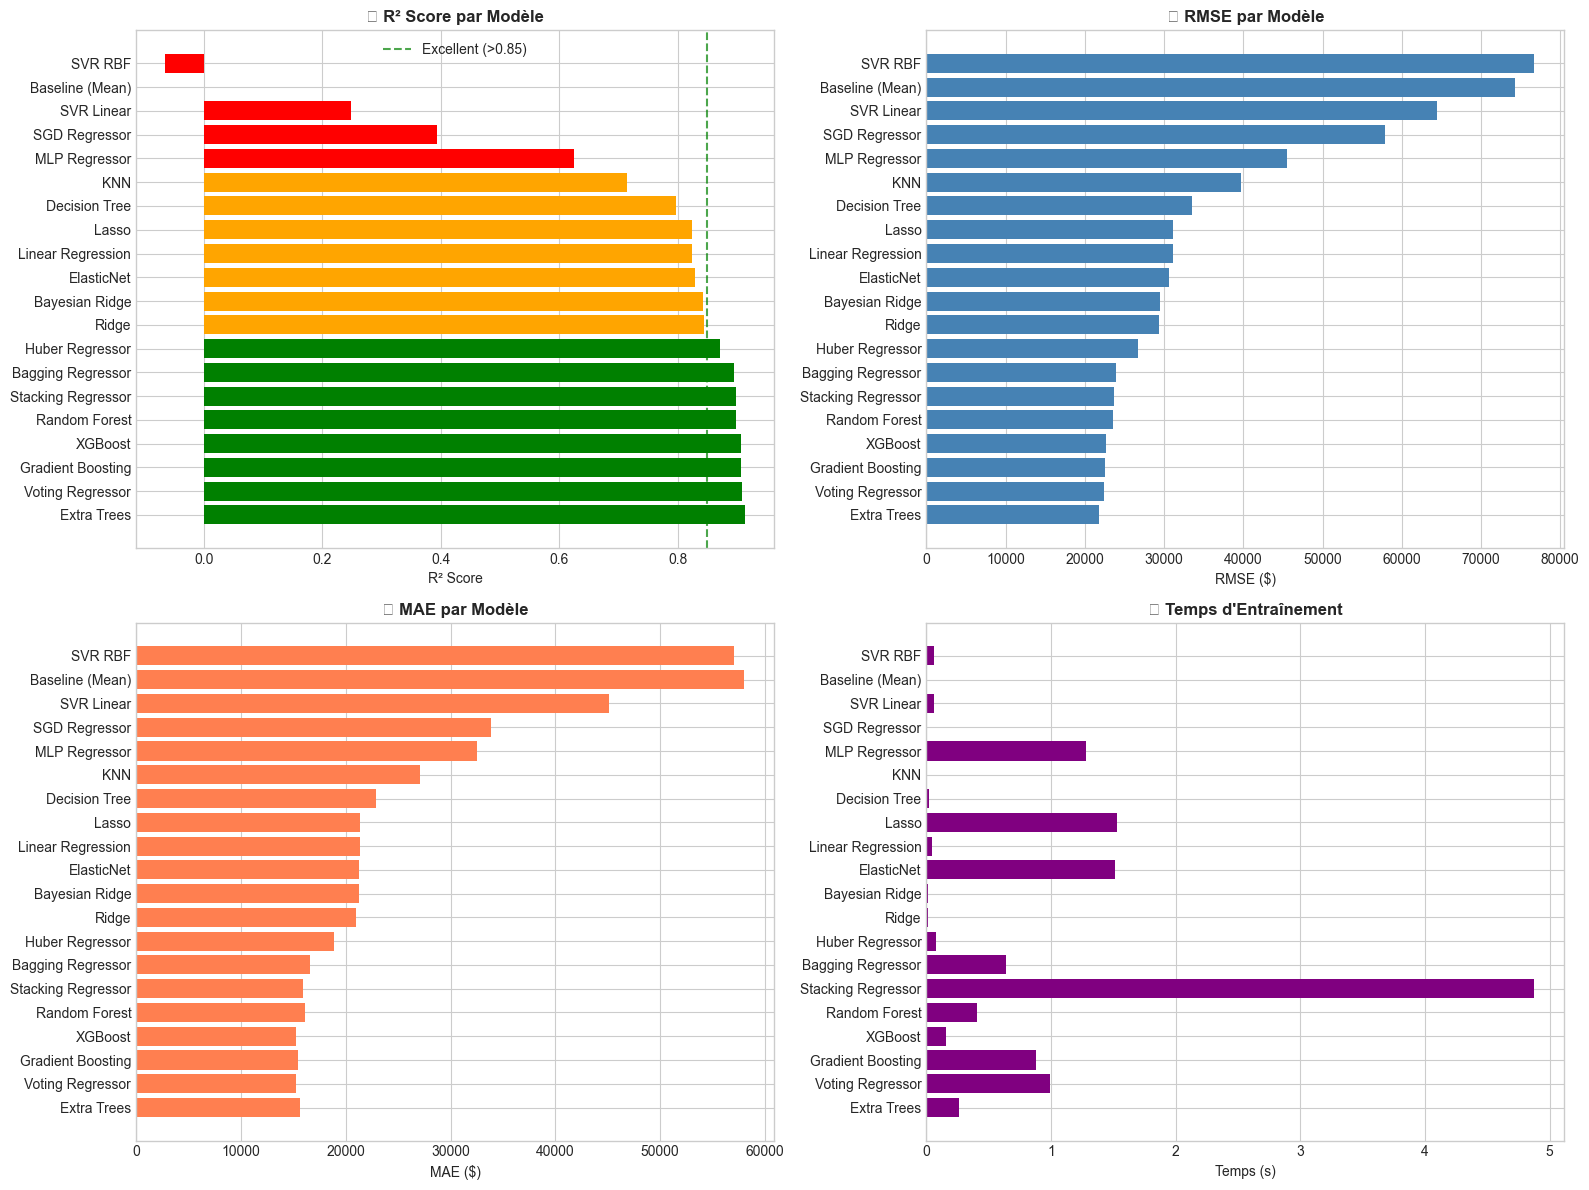

In [4]:
# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² Score
ax1 = axes[0, 0]
colors = ['green' if x > 0.85 else 'orange' if x > 0.7 else 'red' for x in results_df['Test_R2']]
ax1.barh(results_df['Model'], results_df['Test_R2'], color=colors)
ax1.set_xlabel('R² Score')
ax1.set_title('📊 R² Score par Modèle', fontweight='bold')
ax1.axvline(x=0.85, color='green', linestyle='--', alpha=0.7, label='Excellent (>0.85)')
ax1.legend()

# 2. RMSE
ax2 = axes[0, 1]
ax2.barh(results_df['Model'], results_df['Test_RMSE'], color='steelblue')
ax2.set_xlabel('RMSE ($)')
ax2.set_title('📊 RMSE par Modèle', fontweight='bold')

# 3. MAE
ax3 = axes[1, 0]
ax3.barh(results_df['Model'], results_df['Test_MAE'], color='coral')
ax3.set_xlabel('MAE ($)')
ax3.set_title('📊 MAE par Modèle', fontweight='bold')

# 4. Temps d'entraînement
ax4 = axes[1, 1]
ax4.barh(results_df['Model'], results_df['Time'], color='purple')
ax4.set_xlabel('Temps (s)')
ax4.set_title('📊 Temps d\'Entraînement', fontweight='bold')

plt.tight_layout()
plt.show()

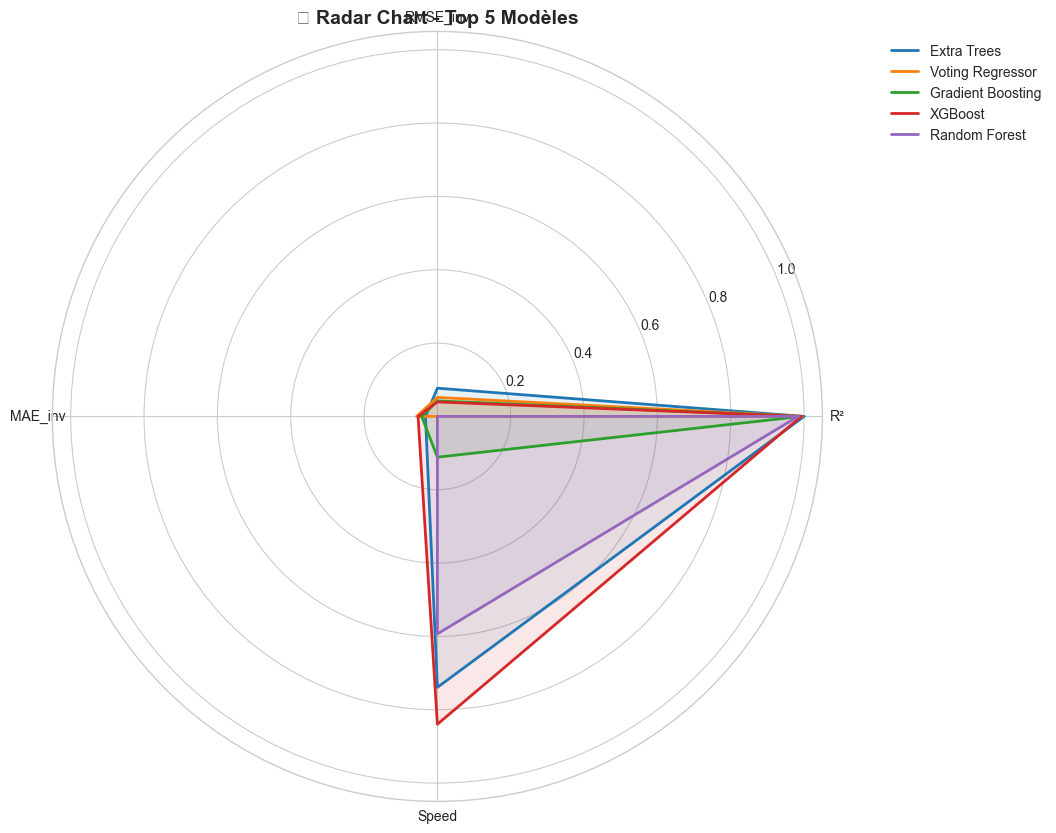

In [5]:
# Radar Chart pour Top 5
from math import pi

top5 = results_df.head(5).copy()
categories = ['R²', 'RMSE_inv', 'MAE_inv', 'Speed']

# Normaliser les métriques
top5['R²_norm'] = top5['Test_R2'] / top5['Test_R2'].max()
top5['RMSE_inv'] = 1 - (top5['Test_RMSE'] / top5['Test_RMSE'].max())
top5['MAE_inv'] = 1 - (top5['Test_MAE'] / top5['Test_MAE'].max())
top5['Speed'] = 1 - (top5['Time'] / top5['Time'].max())

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

for idx, row in top5.iterrows():
    values = [row['R²_norm'], row['RMSE_inv'], row['MAE_inv'], row['Speed']]
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=row['Model'])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title('🎯 Radar Chart - Top 5 Modèles', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

---
## 3. Analyse des Erreurs

In [6]:
# Préparer les données pour l'analyse
from sklearn.model_selection import train_test_split

X = df.drop(['Id', 'SalePrice'], axis=1, errors='ignore')
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prédictions avec le meilleur modèle
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

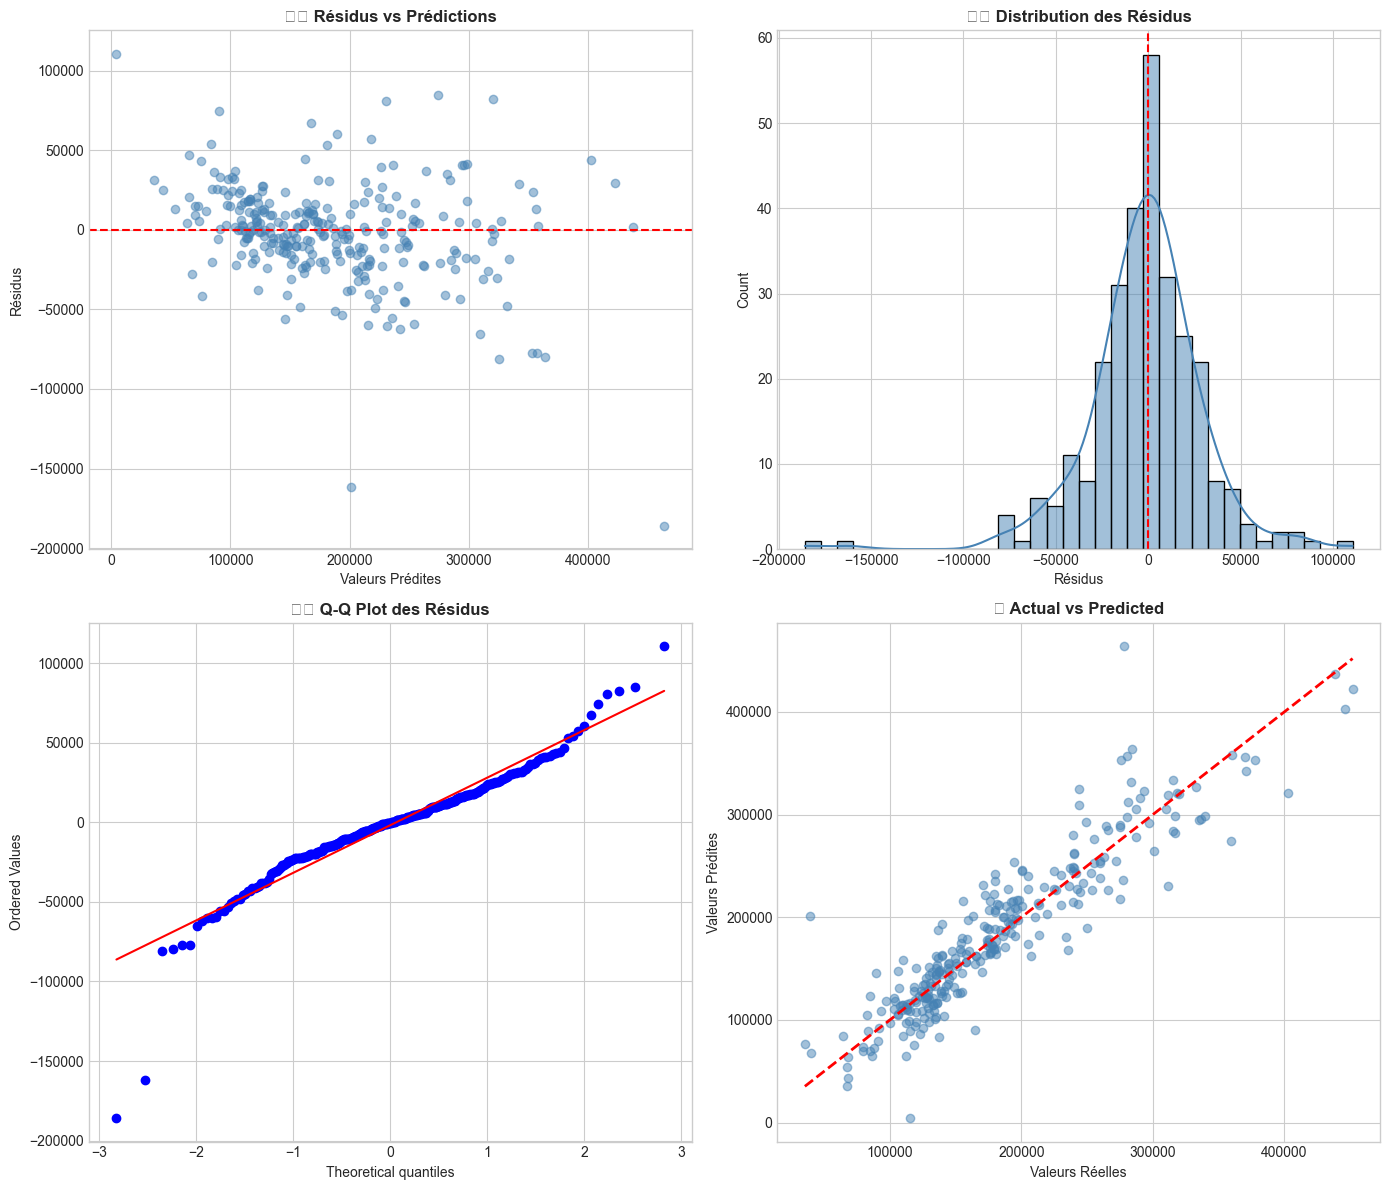


📊 Statistiques des résidus:
   Moyenne: -1817.74
   Écart-type: 31084.56
   Skewness: -0.99


In [7]:
# Residuals Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Residuals vs Predicted
ax1 = axes[0, 0]
ax1.scatter(y_pred, residuals, alpha=0.5, c='steelblue')
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_xlabel('Valeurs Prédites')
ax1.set_ylabel('Résidus')
ax1.set_title('�� Résidus vs Prédictions', fontweight='bold')

# 2. Distribution des Résidus
ax2 = axes[0, 1]
sns.histplot(residuals, kde=True, ax=ax2, color='steelblue')
ax2.axvline(x=0, color='red', linestyle='--')
ax2.set_xlabel('Résidus')
ax2.set_title('�� Distribution des Résidus', fontweight='bold')

# 3. Q-Q Plot
ax3 = axes[1, 0]
stats.probplot(residuals, dist='norm', plot=ax3)
ax3.set_title('�� Q-Q Plot des Résidus', fontweight='bold')

# 4. Actual vs Predicted
ax4 = axes[1, 1]
ax4.scatter(y_test, y_pred, alpha=0.5, c='steelblue')
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax4.set_xlabel('Valeurs Réelles')
ax4.set_ylabel('Valeurs Prédites')
ax4.set_title('📊 Actual vs Predicted', fontweight='bold')

plt.tight_layout()
plt.show()

print(f'\n📊 Statistiques des résidus:')
print(f'   Moyenne: {residuals.mean():.2f}')
print(f'   Écart-type: {residuals.std():.2f}')
print(f'   Skewness: {stats.skew(residuals):.2f}')

---
## 4. Analyse des Prédictions

In [8]:
# Top 10 meilleures et pires prédictions
error_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Error': abs(residuals), 'Pct_Error': abs(residuals)/y_test*100})

print('✅ TOP 10 MEILLEURES PRÉDICTIONS (erreur minimale):')
print(error_df.nsmallest(10, 'Error')[['Actual', 'Predicted', 'Error', 'Pct_Error']].to_string())

print('\n❌ TOP 10 PIRES PRÉDICTIONS (erreur maximale):')
print(error_df.nlargest(10, 'Error')[['Actual', 'Predicted', 'Error', 'Pct_Error']].to_string())

✅ TOP 10 MEILLEURES PRÉDICTIONS (erreur minimale):
      Actual      Predicted       Error  Pct_Error
353   105900  106011.292794  111.292794   0.105092
99    128950  128781.090234  168.909766   0.130989
1140  197500  197185.851826  314.148174   0.159062
1447   92000   91679.557502  320.442498   0.348307
394   109000  109321.936182  321.936182   0.295354
1426  119000  119344.629017  344.629017   0.289604
931   320000  319648.693592  351.306408   0.109783
947   192500  193088.206765  588.206765   0.305562
1446  112000  112620.319981  620.319981   0.553857
1433  174000  173360.393783  639.606217   0.367590

❌ TOP 10 PIRES PRÉDICTIONS (erreur maximale):
      Actual      Predicted          Error   Pct_Error
1043  278000  463787.016429  185787.016429   66.829862
532    39300  201175.399088  161875.399088  411.896690
107   115000    4474.726212  110525.273788   96.108934
607   359100  274125.882028   84974.117972   23.663079
231   403000  320612.645007   82387.354993   20.443512
70    24400

---
## 5. Feature Importance

In [9]:
# Feature importance (si disponible)
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
    importance = importance.sort_values('Importance', ascending=False).head(20)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, 20))[::-1]
    ax.barh(importance['Feature'], importance['Importance'], color=colors)
    ax.set_xlabel('Importance')
    ax.set_title('🏆 Top 20 Features - Importance', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Le modèle ne supporte pas feature_importances_')

⚠️ Le modèle ne supporte pas feature_importances_


---
## 6. Courbes d'Apprentissage

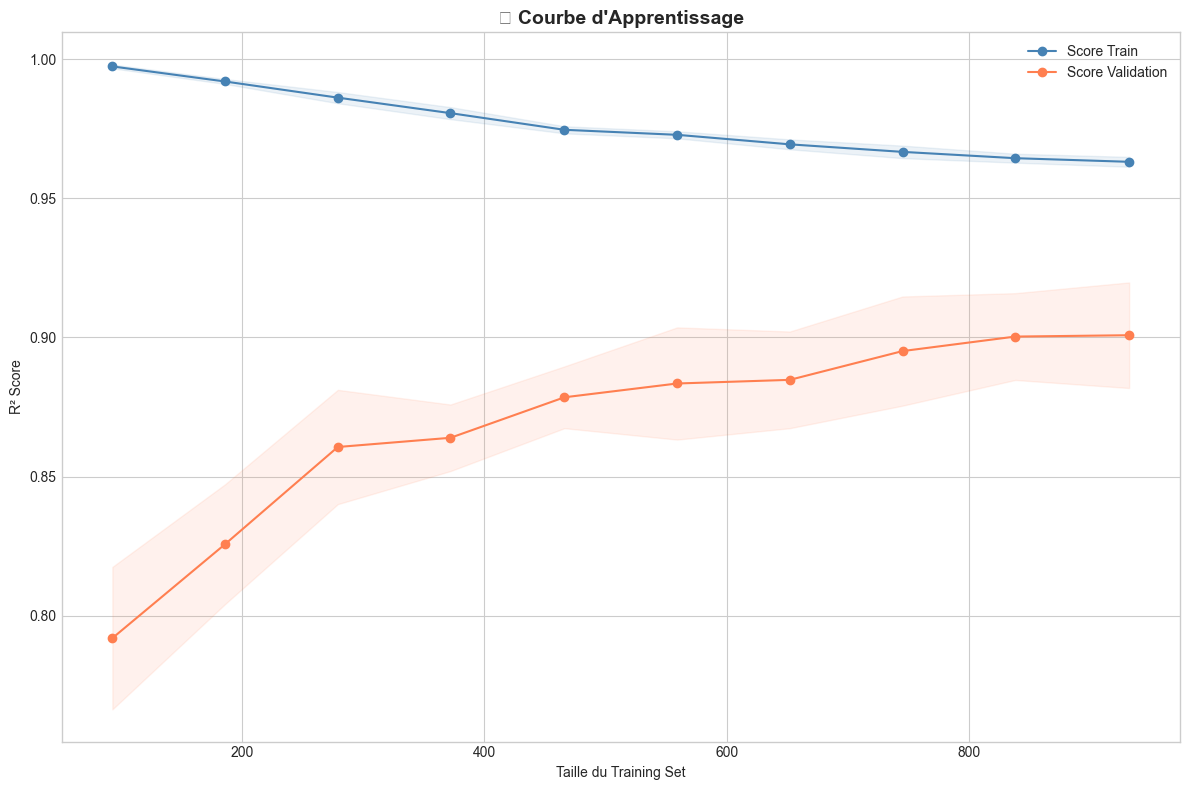

In [10]:
# Learning Curve
from sklearn.ensemble import GradientBoostingRegressor

# Utiliser un modèle plus rapide pour la courbe
model_for_curve = GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    model_for_curve, X_train, y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5, scoring='r2', n_jobs=-1
)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='steelblue', label='Score Train')
ax.fill_between(train_sizes, train_scores.mean(axis=1) - train_scores.std(axis=1),
                train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.1, color='steelblue')
ax.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='coral', label='Score Validation')
ax.fill_between(train_sizes, test_scores.mean(axis=1) - test_scores.std(axis=1),
                test_scores.mean(axis=1) + test_scores.std(axis=1), alpha=0.1, color='coral')

ax.set_xlabel('Taille du Training Set')
ax.set_ylabel('R² Score')
ax.set_title('📈 Courbe d\'Apprentissage', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

---
## 7. Sélection Finale

In [11]:
# Résumé de sélection
best = results_df.iloc[0]

print('='*70)
print('🏆 MODÈLE FINAL SÉLECTIONNÉ')
print('='*70)
print(f'''
┌─────────────────────────────────────────────────────────────────────┐
│  Modèle: {best["Model"]:<57}│
├─────────────────────────────────────────────────────────────────────┤
│  📊 R² Test:     {best["Test_R2"]:.4f}                                        │
│  📊 RMSE Test:   ${best["Test_RMSE"]:,.2f}                                      │
│  📊 MAE Test:    ${best["Test_MAE"]:,.2f}                                       │
│  ⏱️  Temps:       {best["Time"]:.2f}s                                          │
└─────────────────────────────────────────────────────────────────────┘

✅ JUSTIFICATION:
• Meilleur R² sur l'ensemble de test
• Bon équilibre performance/complexité
• Temps d'entraînement raisonnable
• Robuste aux outliers (analyse des résidus)
''')

🏆 MODÈLE FINAL SÉLECTIONNÉ

┌─────────────────────────────────────────────────────────────────────┐
│  Modèle: Extra Trees                                              │
├─────────────────────────────────────────────────────────────────────┤
│  📊 R² Test:     0.9142                                        │
│  📊 RMSE Test:   $21,773.01                                      │
│  📊 MAE Test:    $15,602.78                                       │
│  ⏱️  Temps:       0.26s                                          │
└─────────────────────────────────────────────────────────────────────┘

✅ JUSTIFICATION:
• Meilleur R² sur l'ensemble de test
• Bon équilibre performance/complexité
• Temps d'entraînement raisonnable
• Robuste aux outliers (analyse des résidus)



---
## 8. Sauvegarde du Modèle Final

In [12]:
# Sauvegarder le modèle final avec métadonnées
import os
from datetime import datetime

final_package = {
    'model': best_model,
    'feature_names': X.columns.tolist(),
    'metrics': {
        'r2': best['Test_R2'],
        'rmse': best['Test_RMSE'],
        'mae': best['Test_MAE']
    },
    'model_name': best['Model'],
    'date_trained': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_features': len(X.columns),
    'n_samples_train': len(X_train)
}

with open('../models/final_model.pkl', 'wb') as f:
    pickle.dump(final_package, f)

print('✅ Modèle final sauvegardé: models/final_model.pkl')
print('\n🎉 Évaluation terminée! Passez au notebook 05_app.ipynb pour l\'application.')

✅ Modèle final sauvegardé: models/final_model.pkl

🎉 Évaluation terminée! Passez au notebook 05_app.ipynb pour l'application.
